In [1]:
# Import the packages
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import scipy.stats as st
import statsmodels.formula.api as smf
from sklearn.preprocessing import Normalizer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import r2_score
from sklearn import decomposition
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

# Load the clean data for modeling.

In [2]:
df = pd.read_csv('energydata_clean.csv')
df.head()

,date,Appliances_energy_use,Kitchen_temp,Kitchen_humidity,LivingRoom_temp,livingRoom_humidity,LaundryRoom_temp,LaundryRoom_humidity,OfficeRoom_temp,OfficeRoom_humidity,...,ParentsRoom_temp,ParentsRoom_humidity,Outside_temp,Outside_pressure,Outside_humidity,WindSpeed,Visibility,Dewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [3]:
X = pd.DataFrame(df)
y = df['Appliances_energy_use']
X = X.drop('Appliances_energy_use', axis=1)
X.shape , y.shape

((19219, 27), (19219,))

In [4]:
X['date'] = pd.to_datetime(X['date'])
X['date_ord']=X['date'].map(dt.datetime.toordinal)
X = X.drop(['date','rv1','rv2'], axis=1)
#df['date_ord'] = X['date'].to_datetime
X.shape

(19219, 25)


As we saw during the EDA, there are many features which has multicollinear. These features can impact the regression model. My first approach to handle the multicollinearity will be **variance inflation factor**. Features **having VIF >5** can be considered as multicollinear.

Let's now check the VIF for the features


In [5]:
df_homeTemp= X[['Kitchen_temp','LivingRoom_temp','LaundryRoom_temp','OfficeRoom_temp','Bathroom_temp',
                'IroningRoom_temp','TeenagerRoom_temp','ParentsRoom_temp','Outside_temp']]
vifT = pd.DataFrame()
vifT["VIF_Factor"] = [variance_inflation_factor(df_homeTemp.values, i) for i in range(df_homeTemp.shape[1])]
vifT["features"] = df_homeTemp.columns
vifT.round(1)

,VIF_Factor,features
0,2070.2,Kitchen_temp
1,486.9,LivingRoom_temp
2,1081.5,LaundryRoom_temp
3,774.4,OfficeRoom_temp
4,943.5,Bathroom_temp
5,1091.3,IroningRoom_temp
6,806.0,TeenagerRoom_temp
7,1759.3,ParentsRoom_temp
8,6.6,Outside_temp


In [ ]:
df_homehumid= df[['Kitchen_humidity','livingRoom_humidity','LaundryRoom_humidity','OfficeRoom_humidity',
                   'Bathroom_humidity','OutsideNorth_humidity','IroningRoom_humidity','TeenagerRoom_humidity',
                  'ParentsRoom_humidity','Outside_humidity']]
vifh = pd.DataFrame()
vifh["VIF_Factor"] = [variance_inflation_factor(df_homehumid.values, i) for i in range(df_homehumid.shape[1])]
vifh["features"] = df_homehumid.columns
vifh.round(1)

Variance inflation factor is high for all the features. So, I cannot choose VIF for multicollinearity detection criteria. We will look for other approaches now. I will use ** L1 and L2 regularization using Lasso and Ridge.**

In [7]:
#eigen values
corr = X.corr()
W,V=np.linalg.eig(corr)
W

array([  1.00190897e+01,   7.08895240e+00,   1.90489942e+00,
         1.03971687e+00,   9.89008001e-01,   9.32130437e-01,
         5.97747367e-01,   5.43775232e-01,   4.15080043e-01,
         2.75797888e-01,   1.96816549e-01,   1.57832308e-01,
         1.44833050e-01,   1.24521624e-01,   1.20117805e-01,
         9.81319885e-02,   3.58823031e-03,   1.43871501e-02,
         2.19819675e-02,   2.90913683e-02,   4.35269088e-02,
         4.53253910e-02,   4.99422217e-02,   7.58736242e-02,
         6.78324115e-02])

In [25]:
pd.DataFrame({'Columns': X.columns, 'eigenVal':W})

,Columns,eigenVal
0,Kitchen_temp,10.019090
1,Kitchen_humidity,7.088952
2,LivingRoom_temp,1.904899
3,livingRoom_humidity,1.039717
4,LaundryRoom_temp,0.989008
5,LaundryRoom_humidity,0.932130
6,OfficeRoom_temp,0.597747
7,OfficeRoom_humidity,0.543775
8,Bathroom_temp,0.415080
9,Bathroom_humidity,0.275798


Variance inflation factor is high for all the features. So, I cannot choose VIF for multicollinearity detection criteria. We will look for other approaches now. I will use ** L1 and L2 regularization using Lasso and Ridge.**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42) 
X_train.shape , y_train.shape,  X_test.shape, y_test.shape

((13453, 25), (13453,), (5766, 25), (5766,))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42) 
X_train.shape , y_train.shape,  X_test.shape, y_test.shape

((13453, 25), (13453,), (5766, 25), (5766,))

In [12]:
# Instantiate a lasso regressor: lasso
lasso = Lasso()
# Fit the regressor to the data
lasso.fit(X_train, y_train)
predicted_lasso_y = lasso.predict(X_test)
print("Lasso Mean Squared error:",mean_squared_error(y_test, predicted_lasso_y))
print("Lasso R2 Score:",lasso.score(X_test, y_test))


Lasso Mean Squared error: 9018.67574242
Lasso R2 Score: 0.146715419079


In [13]:
# Instantiate a Ridge regressor
ridg = Ridge()
# Fit the regressor to the data
ridg.fit(X_train, y_train)
predicted_ridg_y = ridg.predict(X_test)
print("Ridge Mean Squared error:",mean_squared_error(y_test, predicted_ridg_y))
print("Ridge R2 Score:",ridg.score(X_test, y_test))

Ridge Mean Squared error: 8979.98107934
Ridge R2 Score: 0.150376439866


In [14]:
# Instantiate a ElasticNet: lasso
elastic_net = ElasticNet()
# Fit the regressor to the data
elastic_net.fit(X_train, y_train)
predicted_elastic_y = elastic_net.predict(X_test)
print("ElasticNet Mean Squared error:",mean_squared_error(y_test, predicted_elastic_y))
print("ElasticNet R2 Score:",elastic_net.score(X_test, y_test))

ElasticNet Mean Squared error: 9241.42893847
ElasticNet R2 Score: 0.125640055802


In [15]:
# The coefficients
pd.DataFrame({'features': X.columns, 'LasoCoefficients': lasso.coef_, 'RidgeCoefficients': ridg.coef_, 'elastic_net':elastic_net.coef_})

,LasoCoefficients,RidgeCoefficients,elastic_net,features
0,-0.000000,0.611995,-0.246477,Kitchen_temp
1,15.904263,17.637433,10.018977,Kitchen_humidity
2,-14.473487,-22.725380,-2.190338,LivingRoom_temp
3,-12.090914,-15.948060,-5.036530,livingRoom_humidity
4,22.792317,26.814391,10.298032,LaundryRoom_temp
5,3.011591,4.476824,3.046194,LaundryRoom_humidity
6,0.000000,3.754061,-0.000000,OfficeRoom_temp
7,0.000000,1.052221,-0.003631,OfficeRoom_humidity
8,-0.000000,-0.421293,-1.326001,Bathroom_temp
9,0.192868,0.218564,0.173005,Bathroom_humidity


In [16]:
#Normalize the training data
scaler = Normalizer().fit(X_train)
normalized_X = scaler.transform(X_train)
#normalized_y = scaler.transform(y_train)
lasso.fit(normalized_X,y_train)
lasso.score(X_test, y_test)

-1.9190335775132183e-05

**R2 score** for the **Lasso, Ridge and ElasticNe**t models are **very low** and also, they have **very high mean squared error value. ** Since R2 is so low, that tuning cannot help much here. Another approach I took to **transform the features** before training the models. Still it didn't improvise the performance of the model. So, decided to go on RandomForestRegressor.

In [17]:
rfreg = RandomForestRegressor()
rfreg.fit(X_train, y_train)
rfreg.score(X_test, y_test)

0.48760276406620812

**RandomForestRegressor** score is way better now which is ** 48%.** So I decided to tune this further for better result.

In [18]:
# Setup the parameters and distributions to sample from: param_dist
param_dist2 = {"n_estimators": [20,50,100],
              "max_depth": [1,5,10,25, None],
              "criterion": ["mse", "mae"],
              "max_features":['auto', "sqrt"],
              "max_leaf_nodes":[2,5,10,None],
              "min_samples_leaf":[1,5,10,25],
              "random_state":[42]}

# Instantiate a Decision Tree classifier: tree
RDtree = RandomForestRegressor()

# Instantiate the RandomizedSearchCV object: tree_cv
RDtree_cv = RandomizedSearchCV (RDtree, param_dist2, cv=5)

# Fit it to the data
RDtree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(RDtree_cv.best_params_))
print("Best score is {}".format(RDtree_cv.best_score_))

Tuned Decision Tree Parameters: {'random_state': 42, 'n_estimators': 50, 'min_samples_leaf': 5, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'mae'}
Best score is 0.16286092528724277


In [19]:
rfreg_tuned = RandomForestRegressor(max_features='sqrt', n_estimators=50, max_depth=25, random_state=42)
rfreg_tuned.fit(X_train, y_train)
pred_reg = rfreg_tuned.predict(X_test)
print("RandomForestRegressor Mean Squared error:",mean_squared_error(y_test, pred_reg))
print("RandomForestRegressor R2 Score:",rfreg_tuned.score(X_test, y_test))

RandomForestRegressor Mean Squared error: 4661.28711512
RandomForestRegressor R2 Score: 0.558981325399


In [20]:
rfreg_tuned.feature_importances_

array([ 0.03388855,  0.05472346,  0.04285769,  0.04645166,  0.04297717,
        0.05240611,  0.03336913,  0.04193859,  0.0380885 ,  0.0480665 ,
        0.03957816,  0.03889683,  0.03355829,  0.04073635,  0.03977629,
        0.05286741,  0.03072646,  0.04279432,  0.03645634,  0.04869265,
        0.04541724,  0.03083879,  0.02384274,  0.0369522 ,  0.02409859])

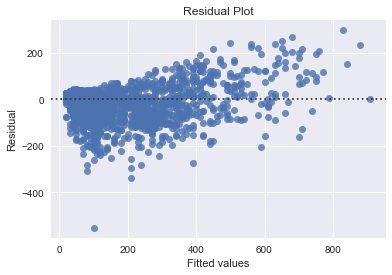

In [21]:
resd = y_test-pred_reg
sns.residplot(y_test, resd)

plt.title("Residual Plot")
plt.xlabel('Fitted values')
plt.ylabel('Residual')
#X.plot(kind='scatter')

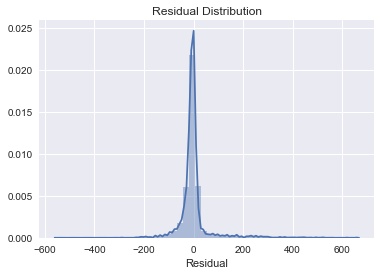

In [26]:
# Ditribution plot of the residuals
sns.distplot(resd)
plt.title("Residual Distribution")
plt.xlabel('Residual')

#X.plot(kind='scatter')

I would recommend **tuned RandomForestRegressor** for the prediction for the energy consumption prediction.